In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("ggplot")

import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

In [ ]:
nltk.download("vader_lexicon", download_dir="./.venv/nltk_data")

In [50]:
df = pd.read_csv("./Reviews.csv")
sub_df = df.head(500)

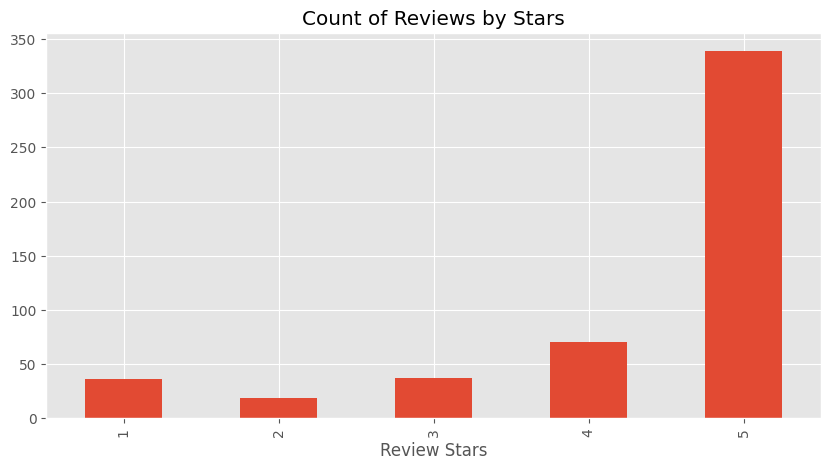

In [51]:
ax = sub_df["Score"].value_counts() \
                .sort_index() \
                .plot(kind="bar", 
                      title="Count of Reviews by Stars", 
                      figsize=(10,5))
ax.set_xlabel("Review Stars")
plt.show()

In [52]:
example = sub_df["Text"][50]
example

"This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go."

In [54]:
tokens = nltk.word_tokenize(example) # NLTK uses PunktSentenceTokenizer
tokens[:10]

['This', 'oatmeal', 'is', 'not', 'good', '.', 'Its', 'mushy', ',', 'soft']

In [56]:
pos_tags = nltk.pos_tag(tokens) # Part of speech tagging, each word relates to a "part of speech", such as Determiner (What is being addressed), adjective, etc
pos_tags[:10]

[('This', 'DT'),
 ('oatmeal', 'NN'),
 ('is', 'VBZ'),
 ('not', 'RB'),
 ('good', 'JJ'),
 ('.', '.'),
 ('Its', 'PRP$'),
 ('mushy', 'NN'),
 (',', ','),
 ('soft', 'JJ')]

In [57]:
entities = nltk.chunk.ne_chunk(pos_tags) # Chunking is grouping related words
entities.pprint()

(S
  This/DT
  oatmeal/NN
  is/VBZ
  not/RB
  good/JJ
  ./.
  Its/PRP$
  mushy/NN
  ,/,
  soft/JJ
  ,/,
  I/PRP
  do/VBP
  n't/RB
  like/VB
  it/PRP
  ./.
  (ORGANIZATION Quaker/NNP Oats/NNPS)
  is/VBZ
  the/DT
  way/NN
  to/TO
  go/VB
  ./.)


## Using VADER (Valence Aware Dictionary and sEntiment Reasoner)
- Uses a bag of words approach

In [59]:
sia = SentimentIntensityAnalyzer()

In [60]:
sia.polarity_scores("I am so happy") # Compound is -1 to 1 to represent the whole sentence

{'neg': 0.0, 'neu': 0.334, 'pos': 0.666, 'compound': 0.6115}

In [63]:
sia.polarity_scores("This is the worst thing ever!")

{'neg': 0.468, 'neu': 0.532, 'pos': 0.0, 'compound': -0.6588}

In [64]:
sia.polarity_scores("This is the best and worst thing ever!")

{'neg': 0.281, 'neu': 0.411, 'pos': 0.308, 'compound': 0.1007}

In [62]:
sia.polarity_scores(example)

{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}

In [65]:
res = {}
for i, row in tqdm(sub_df.iterrows(), total=len(sub_df)):
    text = row["Text"]
    curr_id = row["Id"]
    res[curr_id] = sia.polarity_scores(text)


res_df = pd.DataFrame(res).T
res_df = res_df.reset_index().rename({"index": "Id"}, axis=1)
res_df = res_df.merge(sub_df, how="left")

  0%|          | 0/500 [00:00<?, ?it/s]